<a href="https://colab.research.google.com/github/MaldoAlberto/House-Price/blob/master/House-Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Competencia de predicción de precios de casas

Se llaman los diferentes métodos que se usarán para generar el modelo que, basadaos en una regresión, predecirá el precio de un conjunto de casas. Se usarán los siguientes módulos en Python:

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import norm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.special import boxcox1p

Manda a llamar a los archivos proporcionados por la competencia House Prices: Advanced Regresion Techniques, correspondientes a el conjunto de datos de entrenamiento y los datos de prueba.

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.head())
print(test.head())

   Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000
4   5          60       RL  ...        WD         Normal    250000

[5 rows x 81 columns]
     Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]


Se identifica de cada archivo la columna de id o número de identificación, se separa del archivo y se almacenan en una variable que identifica cada característica en cada columna.

In [0]:
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)
print(train.head())
print(test.head())

   MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
0          60       RL         65.0  ...        WD        Normal    208500
1          20       RL         80.0  ...        WD        Normal    181500
2          60       RL         68.0  ...        WD        Normal    223500
3          70       RL         60.0  ...        WD       Abnorml    140000
4          60       RL         84.0  ...        WD        Normal    250000

[5 rows x 80 columns]
   MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SaleCondition
0          20       RH         80.0  ...    2010       WD        Normal
1          20       RL         81.0  ...    2010       WD        Normal
2          60       RL         74.0  ...    2010       WD        Normal
3          60       RL         78.0  ...    2010       WD        Normal
4         120       RL         43.0  ...    2010       WD        Normal

[5 rows x 79 columns]


Se concatenan en una misma matriz los dos arreglos (tanto de entrenamiento como de prueba) para facilitar establecer una relación entre los datos, por lo que se elimina la columna SalePrice del entrenamiento.

In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Tam Train : {}".format(train.shape))
print("Tam Test : {}".format(test.shape))
print("Tam Total : {}".format(all_data.shape))

Tam Train : (1460, 80)
Tam Test : (1459, 79)
Tam Total : (2919, 79)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


Para buscar un método de regresión adecuado, una técnica de preprocesamiento consite en la separación entre los tipos de datos numéricos y categóricos. Esto se logra mediante la identificacióón de tipo de variable de cada columna en el conjunto de datos:

In [0]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total de atributos : ', cat, 'categoricos', '+', num, 'numericos', '=', cat+num)

Total de atributos :  43 categoricos + 37 numericos = 80


Se identifica de estos 37 atributos los 10 más correlacionados con respecto al atributo $SalePrice$. En este punto, es útil encontrar la correlación entre los pares numéricos que permitan establecer relaciones entre las variables o características.


In [0]:
corrmat = train.corr()
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Atributos mas correlacionados']
print(most_corr)

  Atributos mas correlacionados
0                     SalePrice
1                   OverallQual
2                     GrLivArea
3                    GarageCars
4                    GarageArea
5                   TotalBsmtSF
6                      1stFlrSF
7                      FullBath
8                  TotRmsAbvGrd
9                     YearBuilt


Al identificar los atributos más correlacionados, es posible continuar con el preprocesamiento considerando estas variables como principales en función de la columna objetivo $SalePrice$.


In [0]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
print("Tam Train : {}".format(train.shape))
print("Tam Test : {}".format(test.shape))
print("Tam Total : {}".format(all_data.shape))

Tam Train : (1460, 80)
Tam Test : (1459, 79)
Tam Total : (2919, 80)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


El preprocesamiento se lleva a cabo con el fin de resolver el problema de los valores perdidos, la conversión de atributos categoricos a numéricos y la eliminación de datos que sean redundantes. Con base en el análisis anterior, las características menos correlacionadas no se toman en cuenta para construir la regresión.

In [0]:
all_data = all_data.drop(columns="Alley")
all_data = all_data.drop(columns="BsmtFinType2")
all_data = all_data.drop(columns="Utilities")
all_data = all_data.drop(columns="PoolQC")
all_data = all_data.drop(columns="MiscVal")
all_data = all_data.drop(columns="GarageCond")
all_data = all_data.drop(columns="Exterior2nd")
all_data = all_data.drop(columns="GarageFinish")
print("Tam Total : {}".format(all_data.shape))



Tam Total : (2919, 72)


Usando solamente valores númericos no se toma  en cuenta parte importante de la información de las variables categóricas, por lo que es necesario explorar una forma de incluirlos en la regresión. La conversión de variables categóricas a un código de numeros naturales permite incluirlos en el análisis. 

In [0]:
all_data['MasVnrType'] = all_data['MasVnrType'].map({'BrkCmn':'BrkCmn', 'BrkFace':'BrkFace', 'CBlock':'CBlock', 'None':'None', 'Stone':'Stone', 'NA':'None'})
all_data['ExterQual'] = all_data['ExterQual'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2})
all_data['ExterCond'] = all_data['ExterCond'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2})
all_data['BsmtQual'] = all_data['BsmtQual'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2, 'NA': 1})
all_data['BsmtCond'] = all_data['BsmtCond'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2, 'NA': 1})
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({'Gd': 9, 'Av': 5, 'Mn': 3, 'No': 1, 'NA': 1})
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map({'GLQ': 9, 'ALQ': 7, 'BLQ': 5, 'Rec': 3, 'LWQ': 2, 'Unf':1, 'NA': 0})
all_data['HeatingQC'] = all_data['HeatingQC'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2})
all_data['CentralAir'] = all_data['CentralAir'].map({'Y': '1', 'N': '0'})
all_data['KitchenQual'] = all_data['KitchenQual'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2})
all_data['FireplaceQu'] = all_data['FireplaceQu'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2, 'NA': 0})
all_data['GarageQual'] = all_data['GarageQual'].map({'Ex': 9, 'Gd': 7, 'TA': 5, 'Fa': 3, 'Po': 2, 'NA': 0})
all_data['Fence'] = all_data['Fence'].map({'GdPrv': 9, 'MnPrv': 7, 'GdWo': 5, 'MnWw': 2, 'NA': 0})
all_data['Street'] = all_data['Street'].map({'Grvl': 3, 'Pave': 5})
all_data['LotShape'] = all_data['LotShape'].map({'Reg': 9, 'IR1': 7, 'IR2': 5, 'IR3': 3})
all_data['LotConfig'] = all_data['LotConfig'].map({'Inside': 9, 'Corner': 7, 'CulDSac': 5, 'FR2': 3, 'FR3':1})
all_data['LandSlope'] = all_data['LandSlope'].map({'Gtl': 9, 'Mod': 5, 'Sev':2})
all_data['PavedDrive'] = all_data['PavedDrive'].map({'Y': 9, 'P': 5, 'N':2})
print(all_data.head())

   1stFlrSF  2ndFlrSF  3SsnPorch  ...  YearBuilt YearRemodAdd  YrSold
0       856       854          0  ...       2003         2003    2008
1      1262         0          0  ...       1976         1976    2007
2       920       866          0  ...       2001         2002    2008
3       961       756          0  ...       1915         1970    2006
4      1145      1053          0  ...       2000         2000    2008

[5 rows x 72 columns]


Los valores perdidos son entonces substituidos.


In [0]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('No')
all_data['Fence'] = all_data['Fence'].fillna(0)
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna(0)
all_data['GarageType'] = all_data['GarageType'].fillna('Attchd')
all_data['GarageQual'] = all_data['GarageQual'].fillna(0)
all_data['BsmtQual'] = all_data['BsmtQual'].fillna(0)
all_data['BsmtCond'] = all_data['BsmtCond'].fillna(0)
all_data['BsmtExposure'] = all_data['BsmtExposure'].fillna(0)
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)





print(all_data.head())



   1stFlrSF  2ndFlrSF  3SsnPorch  ...  YearBuilt YearRemodAdd  YrSold
0       856       854          0  ...       2003         2003    2008
1      1262         0          0  ...       1976         1976    2007
2       920       866          0  ...       2001         2002    2008
3       961       756          0  ...       1915         1970    2006
4      1145      1053          0  ...       2000         2000    2008

[5 rows x 72 columns]


Se identifican si hay valores perdidos

In [0]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(missing_data)

             Missing Ratio
SalePrice        49.982871
LotFrontage      16.649538
GarageYrBlt       5.447071


Es importante comprobar que los cambios realizados no afecten otra propiedad del conjunto de datos


In [0]:
cat = len(all_data.select_dtypes(include=['object']).columns)
num = len(all_data.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  20 categorical + 52 numerical = 72 features


Se identifica la nueva correlación con el tratamiento que se tiene.

In [0]:
corrmat = all_data.corr()



k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index


most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
print(most_corr)

  Most Correlated Features
0                SalePrice
1              OverallQual
2                GrLivArea
3                ExterQual
4              KitchenQual
5               GarageCars
6               GarageArea
7              TotalBsmtSF
8                 1stFlrSF
9                 BsmtQual


Se separa la columna objetivo del conjunto de datos tratados y en la sección del entrenamiento se hace un tratamiento logarítmico de esta columna de la forma $ln(x+1)$

In [0]:
all_data.drop(['SalePrice'], axis=1, inplace=True)
 
# log(1+x)
train["SalePrice"] = np.log1p(train["SalePrice"])
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

y_train = train.SalePrice.values


 mu = 12.02 and sigma = 0.40



Se identifica la kurtosis y skewness de los atributos, además se detectan los que estan más concentrados con respecto a la columna objetivo $SalePrice$.

In [0]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())



numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
print(skewness.head())

Skewness: 0.121347
Kurtosis: 0.809519
              Skewed Features
PoolArea            16.898328
LotArea             12.822431
LowQualFinSF        12.088761
3SsnPorch           11.376065
KitchenAbvGr         4.302254


A las variables numéricas del conjunto de datos se le aplica una transformación tipo Box Cox, la cual puede escribirse como:

$ y(x,\lambda ) =
  \begin{cases}
  \frac{(1+x)^{\lambda} - 1}{\lambda}  & \quad \text{si } \lambda \neq 0 \\
    ln(1+x) & \quad \text{si } \lambda =0
  \end{cases}
$

Lo que ayuda a aproximar variables dependientes con una cierta distribución de probabilidad a una distribución normal.

In [0]:
skewness = skewness[abs(skewness) > 0.90]
print("Transformacion Box Cox {}".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.5
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

Transformacion Box Cox 51


In [0]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

print(all_data)

(2919, 200)
      1stFlrSF  2ndFlrSF  3SsnPorch  ...  SaleType_New  SaleType_Oth  SaleType_WD
0     9.033611  9.030336        1.0  ...             0             0            1
1     9.582497  1.000000        1.0  ...             0             0            1
2     9.134745  9.049876        1.0  ...             0             0            1
3     9.196081  8.860236        1.0  ...             0             0            1
4     9.443905  9.325137        1.0  ...             0             0            1
...        ...       ...        ...  ...           ...           ...          ...
2914  8.411283  8.411283        1.0  ...             0             0            1
2915  8.411283  8.411283        1.0  ...             0             0            1
2916  9.538872  1.000000        1.0  ...             0             0            1
2917  9.209212  1.000000        1.0  ...             0             0            1
2918  9.246507  9.257797        1.0  ...             0             0            1

[29

Esto permite validar los últimos valores perdidos tanto para el conjunto de datos de entrenamiento como de prueba mediante la normalización de sus respectivos datos usando sus medias.



In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.values)
train = train.values
test =test.values


from sklearn.preprocessing import  Imputer
imputer = Imputer(strategy = 'mean')

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

[[9.03361062 9.03033585 1.         ... 0.         0.         1.        ]
 [9.58249678 1.         1.         ... 0.         0.         1.        ]
 [9.13474461 9.04987631 1.         ... 0.         0.         1.        ]
 ...
 [9.4963403  9.45256742 1.         ... 0.         0.         1.        ]
 [9.35835716 1.         1.         ... 0.         0.         1.        ]
 [9.57569222 1.         1.         ... 0.         0.         1.        ]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Una técnica común para evaluar la calidad de la regresión es mediante la subdivisión del conjunto de datos de entrenamineto en secciones donde una de ellas será probada con el modelo de la regresión. K-Fold permite hacer dichas subdivisiones:



![texto alternativo](https://drive.google.com/uc?id=1hGsxcMidKv6LO7FxkAs2e2gok-M58J9D)


 Para este modelo se realiza esta técnica con un factor $k=10$ fold de validación cruzada con 10 
-cross validation con 10 iteraicones para promediar su valor con el modelo de regresión lineal multivariable. 

# Regresión lineal Múltiple

El modelo se basa en buscar la correlación que tienen todos los valores con respecto a los datos objetivo "$SalePrice$" o bien, llamada en el modelo la variable dependiente $Y \rightarrow \{ y_{0}, ... , y_{n} \} '$, la cual se describe como:

$Y=X_{np} \cdot b'+e'$

Donde $X_{np}$ es la matriz de $p$ características con $n$ muestras, $b$ es el vector de coeficientes (similar a los pesos en redes neuronales) y $e$ es el vector del error lineal para cada muestra.

El parámetro de medición del error para este caso es el error cuadrático medio negativo, establecido como:

$R^{2}=\frac{\sum_{i=1}^{n}(\hat{y}-\bar{y})^{2}     +2 \sum_{i=1}^{n} (y_{i}-\hat{y})(\hat{y}-\bar{y})   }{\sum_{i=1}^{n}(y_{i}-\hat{y})^{2}+ \sum_{i=1}^{n}(\hat{y}-\bar{y})^{2} + 2 \sum_{i=1}^{n} (y_{i}-\hat{y})(\hat{y}-\bar{y})  }$



In [0]:
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=False, random_state=None)
    kf = kf.get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train,y_train)


i = 0
promedio = 1
score = [0]*promedio
while i < promedio:
    score[i] = rmsle_cv(model)
    i+=1


i = 0
mean = 0.0
std = 0.0

while i < promedio:
    mean += score[i].mean() 
    std += score[i].std()
    i+=1

mean = mean/promedio
std = std/promedio



print("score: {:.4f} ({:.4f})\n".format(mean,std))


test_pred =  np.expm1(model.predict(test))
submit = pd.DataFrame()
submit['ID'] = test_ID
submit['SalePrice'] = test_pred
submit.to_csv('submission_v1.csv',index=False)

submit.head()


score: 0.1337 (0.0205)



,ID,SalePrice
0,1461,116354.325384
1,1462,166889.439062
2,1463,183138.009793
3,1464,194784.942700
4,1465,208154.695176


In [0]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [0]:
# Use seaborn for pairplot
!pip install seaborn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


Se carga el conjunto de datos de entrenamiento para esta prueba.


In [0]:

dataset = train.iloc[:, 0:52]
precio = train.iloc[:, -1]
precios =  pd.DataFrame({'SalePrice': y_train})
dataset.tail()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,SalePrice,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1455,953,694,0,3,5.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0,953.0,0,5,5,0.0,5.0,1,2,460.0,2.0,5.0,1999.0,1647,1,9,1,5.0,9,7917,9,62.0,9,0,60,0.0,8,40,5,6,9,0,175000.0,0,5,7,953.0,0,1999,2000,2007
1456,2073,0,0,3,5.0,1.0,790.0,163.0,7.0,1.0,0.0,7.0,589.0,0,5,5,7.0,5.0,2,2,500.0,2.0,5.0,1978.0,2073,0,5,1,5.0,9,13175,9,85.0,9,0,20,119.0,2,0,6,6,9,0,210000.0,0,5,7,1542.0,349,1978,1988,2010
1457,1188,1152,0,4,7.0,1.0,275.0,0.0,9.0,0.0,0.0,5.0,877.0,0,7,9,9.0,7.0,2,2,252.0,1.0,5.0,1941.0,2340,0,9,1,7.0,9,9042,9,66.0,9,0,70,0.0,5,60,9,7,9,0,266500.0,0,5,9,1152.0,0,1941,2006,2010
1458,1078,0,0,2,5.0,3.0,49.0,1029.0,9.0,1.0,0.0,5.0,0.0,112,5,5,0.0,0.0,0,1,240.0,1.0,5.0,1950.0,1078,0,7,1,7.0,9,9717,9,68.0,9,0,20,0.0,4,0,6,5,9,0,142125.0,0,5,5,1078.0,366,1950,1996,2010
1459,1256,0,0,3,5.0,1.0,830.0,290.0,5.0,1.0,0.0,5.0,136.0,0,5,7,0.0,0.0,0,1,276.0,1.0,5.0,1965.0,1256,1,7,1,5.0,9,9937,9,75.0,9,0,20,0.0,6,68,6,5,9,0,147500.0,0,5,6,1256.0,736,1965,1965,2008


El set de datos contiene algunos valores desconocidos, se sustituyen por 0

In [0]:
dataset = dataset.fillna(0)


Se dividen los datos en entrenamiento y validación. Los datos del archivo de entrenamiento se dividen en subconjuntos tanto de entrenamiento como de validación.

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
val_dataset = dataset.drop(train_dataset.index)
print(train_dataset)

      1stFlrSF  2ndFlrSF  3SsnPorch  ...  YearBuilt  YearRemodAdd  YrSold
529       2515         0          0  ...       1957          1975    2007
491        958       620          0  ...       1941          1950    2006
459        979       224          0  ...       1950          1950    2009
279       1156       866          0  ...       1977          1977    2008
655        525       567          0  ...       1971          1971    2010
...        ...       ...        ...  ...        ...           ...     ...
1168      1236       872          0  ...       1935          1986    2008
455       1242         0          0  ...       1973          1973    2007
584        989       584          0  ...       1935          1995    2009
147        884      1151          0  ...       2001          2001    2010
160       1232         0          0  ...       1984          1984    2008

[1168 rows x 52 columns]


Inspección de los datos

Se revisa la distribución conjunta de un par de columnas de el set de entrenamiento.

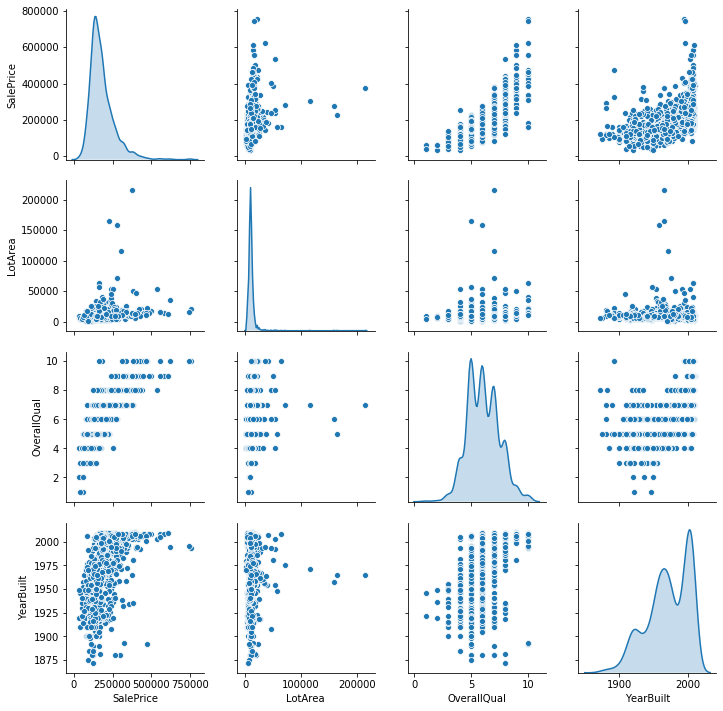

In [0]:
sns.pairplot(train[["SalePrice", "LotArea", "OverallQual", "YearBuilt"]], diag_kind="kde")

Tambien se revisan las estadisticas generales:


In [0]:
train_stats = train_dataset.describe()
#train_stats.pop("SalePrice")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,1168.0,1168.434075,393.668825,334.0,882.00,1096.0,1391.25,4692.0
2ndFlrSF,1168.0,355.280822,441.948969,0.0,0.00,0.0,729.25,2065.0
3SsnPorch,1168.0,3.969178,31.985790,0.0,0.00,0.0,0.00,508.0
BedroomAbvGr,1168.0,2.861301,0.824606,0.0,2.00,3.0,3.00,8.0
BsmtCond,1168.0,4.913527,0.958552,0.0,5.00,5.0,5.00,7.0
BsmtExposure,1168.0,2.509418,2.567995,0.0,1.00,1.0,3.00,9.0
BsmtFinSF1,1168.0,443.898973,467.494644,0.0,0.00,375.0,719.25,5644.0
BsmtFinSF2,1168.0,46.504281,165.306918,0.0,0.00,0.0,0.00,1474.0
BsmtFinType1,1168.0,4.745719,3.499967,0.0,1.00,5.0,9.00,9.0
BsmtFullBath,1168.0,0.429795,0.522209,0.0,0.00,0.0,1.00,3.0


### Separar las caracteristicas de el valor objetivo.

Se separa el valor objetivo, el cual será el valor que entrenara el modelo para predecir.

In [0]:
train_labels = train_dataset.pop('SalePrice')
val_labels = val_dataset.pop('SalePrice')
val_dataset.tail()

NameError: ignored

### Normalizar los datos

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo * podría * converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.


In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_val_data = norm(val_dataset)
normed_train_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
529,3.420555,-0.803896,-0.124092,1.3809,0.090212,-0.587781,1.657989,-0.281321,-0.498782,1.091911,-0.240786,-0.619141,0.538761,2.873247,-0.240058,1.017920,-0.470639,0.569905,2.134379,2.569453,0.030869,0.281892,0.257523,0.237757,1.844937,-0.771454,-1.191945,4.413143,-0.785853,0.227421,2.232723,-2.004260,-1.680656,-0.996085,-0.130482,-0.893461,-0.594513,-1.246116,-0.719942,-2.300425,-0.109175,0.28666,-0.071073,-0.263795,0.058596,1.491086,2.155813,-0.763560,-0.458354,-0.484615,-0.621407
491,-0.534546,0.598981,-0.124092,0.1682,0.090212,-0.587781,-0.087485,0.716823,0.072652,1.091911,-0.240786,-0.619141,-0.758487,0.146757,-0.240058,-0.702674,2.029651,0.569905,2.134379,-1.018259,-1.083701,-1.024655,0.257523,0.164003,0.088765,-0.771454,-1.191945,-0.218080,-2.290568,0.227421,-0.106944,0.525157,0.613051,0.697405,-0.130482,-0.180077,-0.594513,0.604677,-0.719942,1.257200,-0.109175,0.28666,-0.071073,-0.263795,0.058596,-0.946407,-0.579441,-0.763560,-0.975546,-1.685562,-1.379822
459,-0.481202,-0.297050,-0.124092,0.1682,0.090212,-0.587781,-0.553801,-0.281321,-1.355933,1.091911,-0.240786,-0.619141,-0.116596,3.652244,-0.240058,-0.702674,-0.470639,0.569905,0.585960,-1.018259,-0.572095,-1.024655,0.257523,0.183526,-0.614078,-0.771454,-1.191945,-0.218080,0.718862,0.227421,-0.356779,-0.739551,-1.680656,-0.996085,-0.130482,-0.180077,0.310374,0.234518,-0.719942,-1.411019,-0.821556,0.28666,-0.071073,-0.263795,0.058596,-0.946407,-0.795324,-0.763560,-0.684626,-1.685562,0.895423
279,-0.031585,1.155607,-0.124092,1.3809,0.090212,-0.587781,-0.111015,-0.281321,0.072652,-0.823032,-0.240786,0.582116,0.431031,-0.372575,-0.240058,-0.702674,-0.470639,0.569905,0.585960,0.775597,0.126795,0.281892,0.257523,0.242095,0.920932,1.200227,0.882083,-0.218080,-0.785853,0.227421,-0.054958,0.525157,0.729188,0.697405,-0.130482,0.057718,1.085992,-1.246116,1.071275,-0.521612,0.603206,0.28666,-0.071073,-0.263795,0.058596,0.881713,0.208419,1.566816,0.188135,-0.388539,0.137008
655,-1.634455,0.479058,-0.124092,0.1682,0.090212,-0.587781,-0.949527,-0.281321,-1.070216,-0.823032,-0.240786,-0.619141,-0.114352,-0.372575,-0.240058,-0.702674,-0.470639,-1.013466,-0.962459,-1.018259,-0.974071,-1.024655,0.257523,0.229080,-0.822120,1.200227,-1.191945,-0.218080,-0.785853,0.227421,-0.895312,0.525157,-1.070937,0.697405,-0.130482,2.435666,1.546866,-1.246116,-0.719942,-0.521612,-0.109175,0.28666,-0.071073,-0.263795,0.058596,-0.337033,-1.204833,-0.763560,-0.005812,-0.676767,1.653838


Estos datos normalizados es lo que usaremos para entrenar el modelo.

### El modelo

### Construcción del modelo

Se utilizará un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo..

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(50, activation='relu'),
    layers.Dense(1, activation='relu')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  return model

model = build_model()

### Inspección del modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               5200      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

Se entrena  el modelo durante 2000 épocas y registre la precisión de entrenamiento y validación en el objeto `history`.

In [0]:
# Display training progress by printing a single dot for each completed epoch
EPOCHS = 2000
class printdot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks = [printdot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Se puede visualizar el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,rmse,val_loss,val_mae,val_mse,val_rmse,epoch
1995,4.388224e+08,11323.823242,438822400.0,20948.087891,8.970044e+08,19730.613281,897004352.0,29950.031250,1995
1996,4.377237e+08,11267.424805,437723680.0,20921.847656,8.906430e+08,19736.695312,890643072.0,29843.644531,1996
1997,4.386237e+08,11299.214844,438623680.0,20943.343750,8.864101e+08,19754.931641,886410112.0,29772.640625,1997
1998,4.383016e+08,11299.137695,438301696.0,20935.656250,8.878888e+08,19738.482422,887888768.0,29797.462891,1998
1999,4.386348e+08,11266.069336,438634720.0,20943.607422,8.883172e+08,19734.203125,888317184.0,29804.650391,1999


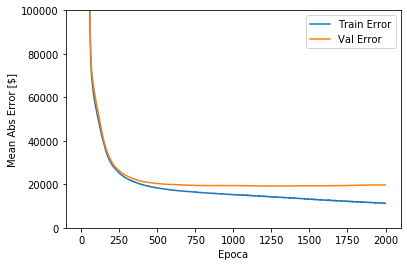

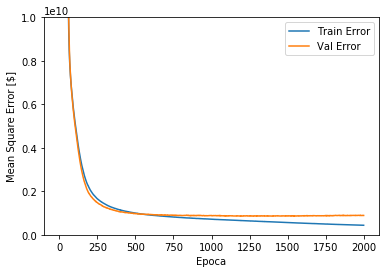

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoca')
  plt.ylabel('Mean Abs Error [$]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,100000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoca')
  plt.ylabel('Mean Square Error [$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,10000000000])
  plt.legend()

  


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 1000 épocas. Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una * devolución de llamada de EarlyStopping * que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.

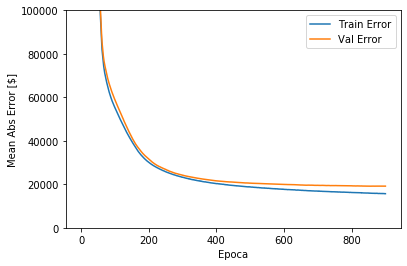

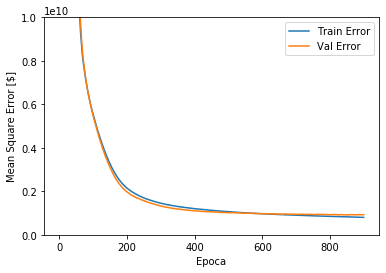

In [0]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=2000,validation_split = 0.2, verbose=0, callbacks=[early_stop , printdot()])

plot_history(history)

### Inspección de las predicciones

Se grafican los valores predecidos para el conjunto de datos de validación contra el precio en el Dataset

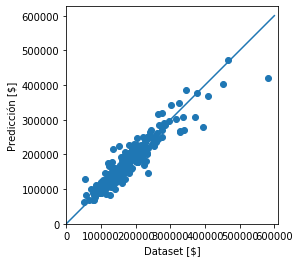

In [0]:
val_predictions = model.predict(normed_val_data).flatten()

plt.scatter(val_labels, val_predictions)
plt.xlabel('Dataset [$]')
plt.ylabel('Predicción [$]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 600000], [0, 600000])

Se puede observar la distribución de errores.

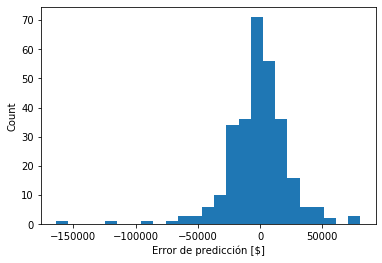

In [0]:
error = val_predictions - val_labels
plt.hist(error, bins = 25)
plt.xlabel("Error de predicción [$]")
_ = plt.ylabel("Count")

## Reentrenamiento con todos los datos

Para obtener un mejor modelo, se reentrena la red neuronal con la totalidad de las instancias contenidas en el archivo train, conservando la arquitectura de la red neuronal y el número de épocas.

In [0]:
todo_labels = dataset.pop('SalePrice')


KeyError: ignored

In [0]:
normed_data = norm(dataset)
normed_data.head()


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.793647,1.128454,-0.124092,0.1682,0.090212,-0.587781,0.560650,-0.281321,1.215520,1.091911,-0.240786,0.582116,-0.955992,-0.372575,-0.240058,1.017920,-0.470639,-1.013466,-0.962459,0.775597,0.323215,0.281892,0.257523,0.298495,0.336166,1.200227,0.882083,-0.21808,0.718862,0.227421,-0.211925,0.525157,0.206571,0.697405,-0.130482,0.057718,0.507089,-1.616275,0.213940,-0.521612,0.603206,0.28666,-0.071073,-0.263795,0.058596,0.881713,-0.468162,-0.763560,1.028571,0.860446,0.137008
1,0.237677,-0.803896,-0.124092,0.1682,0.090212,2.527490,1.142475,-0.281321,0.644086,-0.823032,4.020390,0.582116,-0.655246,-0.372575,-0.240058,-0.702674,-0.470639,0.569905,0.585960,0.775597,-0.078761,0.281892,0.257523,0.239926,-0.503497,-0.771454,0.882083,-0.21808,-0.785853,0.227421,-0.095840,-3.268968,0.642085,0.697405,-0.130482,-0.893461,-0.594513,-0.505799,-0.719942,2.146607,-0.109175,0.28666,-0.071073,-0.263795,0.058596,-0.337033,0.435429,1.647732,0.155811,-0.436577,-0.621407
2,-0.631074,1.155607,-0.124092,0.1682,0.090212,0.191037,0.090057,-0.281321,1.215520,1.091911,-0.240786,0.582116,-0.318590,-0.372575,-0.240058,1.017920,-0.470639,0.569905,0.585960,0.775597,0.597289,0.281892,0.257523,0.294157,0.478609,1.200227,0.882083,-0.21808,0.718862,0.227421,0.070717,0.525157,0.293674,-0.996085,-0.130482,0.057718,0.315994,0.974836,-0.076941,-0.521612,0.603206,0.28666,-0.071073,-0.263795,0.058596,-0.337033,-0.325724,-0.763560,0.963922,0.812408,0.137008
3,-0.526925,0.906709,-0.124092,0.1682,2.176691,-0.587781,-0.487490,-0.281321,0.644086,1.091911,-0.240786,-0.619141,-0.080686,4.041743,-0.240058,-0.702674,-0.470639,1.203253,0.585960,-1.018259,0.752598,1.588438,0.257523,0.287649,0.349286,-0.771454,-0.154931,-0.21808,0.718862,0.227421,-0.100887,-0.739551,0.061400,-0.996085,-0.130482,0.295513,-0.594513,-1.616275,-0.184108,-0.521612,0.603206,0.28666,-0.071073,-0.263795,0.058596,0.272340,-0.690721,-0.763560,-1.815982,-0.724804,-1.379822
4,-0.059527,1.578732,-0.124092,1.3809,0.090212,0.969855,0.451558,-0.281321,1.215520,1.091911,-0.240786,0.582116,-0.192905,-0.372575,-0.240058,1.017920,-0.470639,0.569905,0.585960,0.775597,1.638772,1.588438,0.257523,0.291987,1.250800,1.200227,0.882083,-0.21808,0.718862,0.227421,0.374556,-3.268968,0.758222,-0.996085,-0.130482,0.057718,1.372633,2.085312,0.566060,-0.521612,1.315587,0.28666,-0.071073,-0.263795,0.058596,1.491086,0.175035,0.790024,0.931598,0.716332,0.137008


In [0]:
model = build_model()


history = model.fit(normed_data, todo_labels, epochs=1100,validation_split = 0, verbose=0, callbacks=[ printdot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Generar predicciones

Se realizan las predicciones de los datos contenidos en el archivo de prueba con los siguientes resultados:

In [0]:
dataset2 = test.iloc[:, 0:52]
dataset2.head()
a = dataset2.pop('SalePrice') 


In [0]:
dataset2 = dataset2.fillna(0)
dataset2.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1460,896,0,0,2,5.0,1.0,468.0,144.0,3.0,0.0,0.0,5.0,270.0,0,5,5,7.0,0.0,0,1,730.0,1.0,5.0,1961.0,896,0,5,1,5.0,9,11622,9,80.0,9,0,20,0.0,6,0,6,5,9,0,120,5,5,882.0,140,1961,1961,2010
1461,1329,0,0,3,5.0,1.0,923.0,0.0,7.0,0.0,0.0,5.0,406.0,0,5,5,0.0,0.0,0,1,312.0,1.0,5.0,1958.0,1329,1,5,1,7.0,9,14267,7,81.0,7,0,20,108.0,6,36,6,6,9,0,0,5,6,1329.0,393,1958,1958,2010
1462,928,701,0,3,5.0,1.0,791.0,0.0,9.0,0.0,0.0,7.0,137.0,0,5,5,7.0,5.0,1,2,482.0,2.0,5.0,1997.0,1629,1,7,1,5.0,9,13830,9,74.0,7,0,60,0.0,3,34,5,5,9,0,0,5,6,928.0,212,1997,1998,2010
1463,926,678,0,3,5.0,1.0,602.0,0.0,9.0,0.0,0.0,5.0,324.0,0,5,5,0.0,7.0,1,2,470.0,2.0,5.0,1998.0,1604,1,9,1,7.0,9,9978,9,78.0,7,0,60,20.0,6,36,6,6,9,0,0,5,7,926.0,360,1998,1998,2010
1464,1280,0,0,2,5.0,1.0,263.0,0.0,7.0,0.0,0.0,7.0,1017.0,0,5,7,0.0,0.0,0,2,506.0,2.0,5.0,1992.0,1280,0,9,1,7.0,9,5005,9,43.0,7,0,120,0.0,1,82,5,8,9,0,144,5,5,1280.0,0,1992,1992,2010


In [0]:
normed_test2_data = norm(dataset2)
normed_test2_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,GarageArea,GarageCars,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
1460,-0.692039,-0.803896,-0.124092,-1.044501,0.090212,-0.587781,0.051554,0.589786,-0.498782,-0.823032,-0.240786,-0.619141,-0.686667,-0.372575,-0.240058,-0.702674,2.029651,-1.013466,-0.962459,-1.018259,1.154574,-1.024655,0.257523,0.207388,-1.189473,-0.771454,-1.191945,-0.21808,-0.785853,0.227421,0.108268,0.525157,0.642085,0.697405,-0.130482,-0.893461,-0.594513,-0.135640,-0.719942,0.367794,-0.821556,0.28666,-0.071073,1.930216,0.058596,-0.946407,-0.410296,0.369262,-0.329056,-1.157145,1.653838
1461,0.407871,-0.803896,-0.124092,0.168200,0.090212,-0.587781,1.024827,-0.281321,0.644086,-0.823032,-0.240786,-0.619141,-0.381432,-0.372575,-0.240058,-0.702674,-0.470639,-1.013466,-0.962459,-1.018259,-0.754811,-1.024655,0.257523,0.200880,-0.377923,1.200227,-1.191945,-0.21808,0.718862,0.227421,0.375263,-0.739551,0.671119,-0.996085,-0.130482,-0.893461,0.012492,-0.135640,-0.168798,0.367794,-0.109175,0.28666,-0.071073,-0.263795,0.058596,-0.337033,0.584544,2.416432,-0.426030,-1.301259,1.653838
1462,-0.610752,0.782260,-0.124092,0.168200,0.090212,-0.587781,0.742471,-0.281321,1.215520,-0.823032,-0.240786,0.582116,-0.985169,-0.372575,-0.240058,-0.702674,2.029651,0.569905,0.585960,0.775597,0.021733,0.281892,0.257523,0.285480,0.184352,1.200227,-0.154931,-0.21808,-0.785853,0.227421,0.331151,0.525157,0.467879,-0.996085,-0.130482,0.057718,-0.594513,-1.246116,-0.199417,-0.521612,-0.821556,0.28666,-0.071073,-0.263795,0.058596,-0.337033,-0.307919,0.951856,0.834624,0.620256,1.653838
1463,-0.615833,0.730218,-0.124092,0.168200,0.090212,-0.587781,0.338188,-0.281321,1.215520,-0.823032,-0.240786,-0.619141,-0.565471,-0.372575,-0.240058,-0.702674,-0.470639,1.203253,0.585960,0.775597,-0.033082,0.281892,0.257523,0.287649,0.137496,1.200227,0.882083,-0.21808,0.718862,0.227421,-0.057683,0.525157,0.584016,-0.996085,-0.130482,0.057718,-0.482105,-0.135640,-0.168798,0.367794,-0.109175,0.28666,-0.071073,-0.263795,0.058596,0.272340,-0.312370,2.149410,0.866949,0.620256,1.653838
1464,0.283400,-0.803896,-0.124092,-1.044501,0.090212,-0.587781,-0.386954,-0.281321,0.644086,-0.823032,-0.240786,0.582116,0.989880,-0.372575,-0.240058,1.017920,-0.470639,-1.013466,-0.962459,0.775597,0.131363,0.281892,0.257523,0.274634,-0.469761,-0.771454,0.882083,-0.21808,0.718862,0.227421,-0.559675,0.525157,-0.432183,-0.996085,-0.130482,1.484487,-0.594513,-1.986434,0.535441,-0.521612,1.315587,0.28666,-0.071073,2.369018,0.058596,-0.946407,0.475490,-0.763560,0.673002,0.332029,1.653838


In [0]:
ynew = model.predict(normed_test2_data)
dfsal = pd.DataFrame(ynew)
dfsal.columns = ['SalePrice']

Se guardan los datos en el archivo de resultados en el drive


In [0]:
my_list = list(range(1461,2920))
dfid = pd.DataFrame(my_list)
dfid.columns = ['Id'] 
resultados = pd.concat([
    dfid,dfsal
], axis=1)
print(resultados)
resultados.to_csv("submission_v2.csv", index=False)

        Id      SalePrice
0     1461  112565.804688
1     1462  165435.750000
2     1463  175896.234375
3     1464  194858.218750
4     1465  178948.171875
...    ...            ...
1454  2915  107731.226562
1455  2916   96195.640625
1456  2917  182300.687500
1457  2918  103606.703125
1458  2919  234564.953125

[1459 rows x 2 columns]


#Resultados de Kaggle:



modelo 1


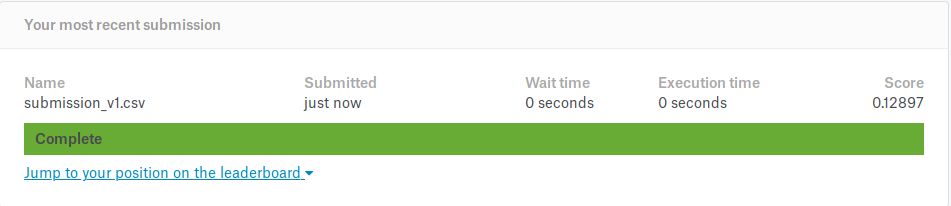

In [0]:
from IPython.display import Image
print("modelo 1")
Image('modelo1.png')

modelo 2


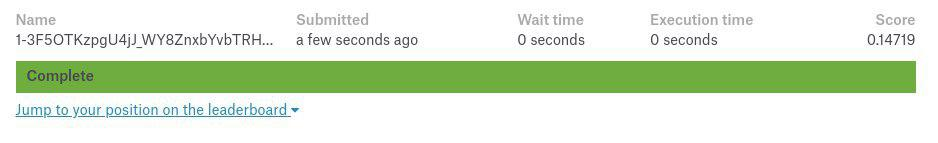

In [0]:
from IPython.display import Image
print("modelo 2")
Image('modelo2.jpg')

#Conclusiones


El reto de este trabajo fue identificar las características que tienen los datos, como son los perdidos, diferentes tipos (categóricos, nominales, binarios y numéricos) como la razón de lo datos para validar si era mejor mantener ciertas variables o instancias. Por otra parte, al no tener un gran número de instancias (1640) y de atributos (80) se tuvo que planear cuales datos existían una mayor relación para poder identificarlos y poder obtener un mejor resultado, esto llevo a proponer varios modelos de los cuales dos son los que reportamos, estos los hemos visto en clase y vimos que el más sencillo en complejidad (regresión lineal) tiene un mejor desempeño que el de redes neuronales, que es más comunmente utilizado para procesos con mayor número de datos y relaciones entre variables mucho más complicados que otros modelos no pueden predecir.

La correcta selección de un método adecuado y de preprocesamiento son indispensables para lograr buenos resultados en este tipo de técnicas de regresión y que presenten una buena estabilidad que sea lo suficientemente general y robusto para evitar los problemas clásicos como el sobre entrenamiento y errores relativos altos.

